## 1. Implementation of Double DQN
let's set up the basic structure for the Double DQN. This requires defining the neural network architecture, the experience replay buffer, and the main training loop.

In [2]:
# Required Libraries
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

In [3]:
# Neural Network Architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        # Define the network layers
        self.network = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.network(x)

In [4]:
# Replay Buffer to store experience tuples
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [12]:
class DDQNAgent:
    def __init__(self, state_size, action_size, buffer_size=10000, batch_size=64,
                 learning_rate=1e-3, gamma=0.99, epsilon_decay=0.995, min_epsilon=0.01):
        # Initialize attributes
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = 1.0  # Starting value of epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize the two networks required for DDQN
        self.policy_net = DQN(state_size, action_size).to(self.device)
        self.target_net = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayBuffer(buffer_size)
        self.update_target_network()

    def update_target_network(self):
        """Update weights in the target network with those from the policy network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def act(self, state):
        """Select an action based on the current state and policy network."""
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()

        # Epsilon-greedy action selection
        if random.random() > self.epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.randrange(self.action_size)

    def learn(self):
        """Update the policy network based on a batch of experiences."""
        if len(self.memory) < self.batch_size:
            return

        experiences = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*experiences))

        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(dones.astype(int)).float().to(self.device)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        # Compute V(s_{t+1}) for all next states, by taking the max Q-value among all actions
        next_q_values = self.target_net(next_states).max(1)[0]
        # Compute the expected Q values
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute the loss
        loss = nn.MSELoss()(current_q_values, expected_q_values)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)




In [20]:
# Additional function to calculate moving average
def moving_average(x, periods=100):
    return np.convolve(x, np.ones(periods)/periods, mode='valid')

In [21]:
# Function to one-hot encode states for the FrozenLake environment
def one_hot_encode(state, state_size):
    """One-hot encode a state."""
    return np.eye(state_size)[state]

## 2. Training the Agent on Frozen Lake

In [22]:
# Training loop for DDQN
def train_ddqn(env, agent, num_episodes=2000):
    episode_rewards = []
    episode_lengths = []
    epsilon_values = []
    for episode in range(num_episodes):
        state = one_hot_encode(env.reset(), env.observation_space.n)
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = one_hot_encode(next_state, env.observation_space.n)

            # Save experience to replay buffer
            agent.memory.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            step_count += 1
            agent.learn()

        # Periodically update the target network
        if episode % agent.batch_size == 0:
            agent.update_target_network()

        episode_rewards.append(total_reward)
        episode_lengths.append(step_count)
        epsilon_values.append(agent.epsilon)
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}: Average Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

    return episode_rewards, episode_lengths, epsilon_values


In [24]:
# Initialize the gym environment
env = gym.make('FrozenLake-v1', is_slippery=True)
state_size = env.observation_space.n
action_size = env.action_space.n


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [25]:
# Instantiate the agent
agent = DDQNAgent(state_size, action_size)


In [26]:
# Train the agent
print("Training the DDQN agent on Frozen Lake...")
rewards, lengths, epsilons = train_ddqn(env, agent)

Training the DDQN agent on Frozen Lake...
Episode 100: Average Reward: 0.10, Epsilon: 0.01
Episode 200: Average Reward: 0.39, Epsilon: 0.01
Episode 300: Average Reward: 0.23, Epsilon: 0.01
Episode 400: Average Reward: 0.51, Epsilon: 0.01
Episode 500: Average Reward: 0.46, Epsilon: 0.01
Episode 600: Average Reward: 0.51, Epsilon: 0.01
Episode 700: Average Reward: 0.51, Epsilon: 0.01
Episode 800: Average Reward: 0.61, Epsilon: 0.01
Episode 900: Average Reward: 0.62, Epsilon: 0.01
Episode 1000: Average Reward: 0.59, Epsilon: 0.01
Episode 1100: Average Reward: 0.62, Epsilon: 0.01
Episode 1200: Average Reward: 0.57, Epsilon: 0.01
Episode 1300: Average Reward: 0.69, Epsilon: 0.01
Episode 1400: Average Reward: 0.61, Epsilon: 0.01
Episode 1500: Average Reward: 0.70, Epsilon: 0.01
Episode 1600: Average Reward: 0.71, Epsilon: 0.01
Episode 1700: Average Reward: 0.61, Epsilon: 0.01
Episode 1800: Average Reward: 0.66, Epsilon: 0.01
Episode 1900: Average Reward: 0.70, Epsilon: 0.01
Episode 2000: Ave

In [27]:
# Plot the learning curve and additional metrics
plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

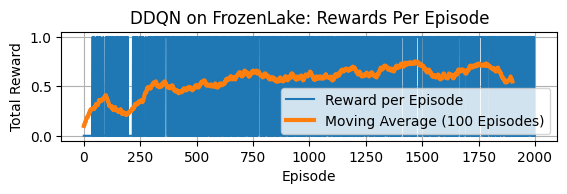

In [29]:
# Subplot 1: Rewards per Episode
plt.subplot(3, 1, 1)
plt.plot(rewards, label='Reward per Episode')
plt.plot(moving_average(rewards, periods=100), label='Moving Average (100 Episodes)', linewidth=3)
plt.title('DDQN on FrozenLake: Rewards Per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()

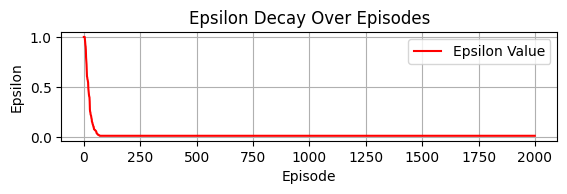

In [30]:
# Subplot 2: Epsilon Decay
plt.subplot(3, 1, 2)
plt.plot(epsilons, label='Epsilon Value', color='r')
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.legend()
plt.grid()

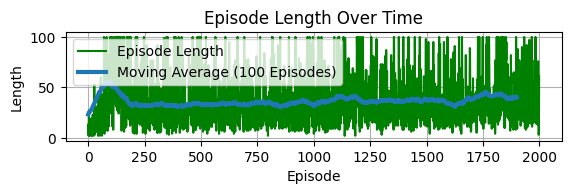

In [31]:
# Subplot 3: Episode Lengths
plt.subplot(3, 1, 3)
plt.plot(lengths, label='Episode Length', color='g')
plt.plot(moving_average(lengths, periods=100), label='Moving Average (100 Episodes)', linewidth=3)
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.legend()
plt.grid()

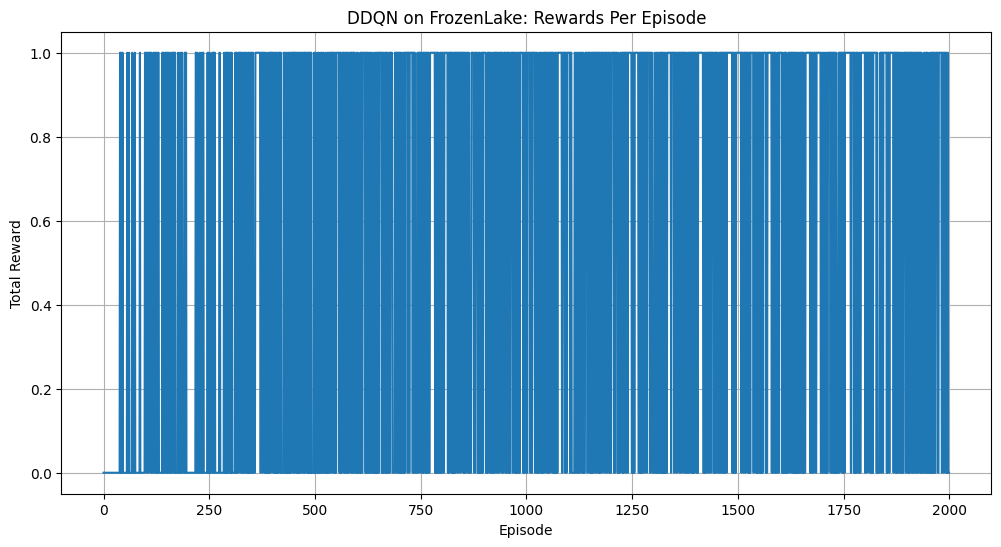

In [33]:
# Plot the learning curve
plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.title('DDQN on FrozenLake: Rewards Per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid()
plt.show()